# Neural Networks for 3D printer data

In [2]:
import pandas as pd

# Load the data into a dataframe
df = pd.read_csv('data/DATA_1.csv', delimiter=';', decimal=',')
print(df)

      mat  no  lpow  lspeed  dist  vol  thick       sken   shap angle     Ra  \
0   FeSi3   1   255     653  0.09  108   0.04  Stripe 10  Kvádr   90°  17.32   
1     NaN   2   255     633  0.09  112   0.04  Stripe 10  Kvádr   90°  22.22   
2     NaN   3   255     643  0.09  110   0.04  Stripe 10  Kvádr   90°  23.57   
3     NaN   4   245     643  0.09  106   0.04  Stripe 10  Kvádr   90°  21.34   
4     NaN   5   265     643  0.09  114   0.04  Stripe 10  Kvádr   90°  18.80   
5     NaN   6   255     644  0.09  110   0.04  Stripe 10  Kvádr   90°  18.73   
6     NaN   7   230     750  0.08   96   0.04  Stripe 10  Kvádr   90°  11.94   
7     NaN   8   270     760  0.08  111   0.04  Stripe 10  Kvádr   90°  11.23   
8     NaN   9   270     740  0.08  114   0.04  Stripe 10  Kvádr   90°  11.14   
9     NaN  10   270     750  0.08  113   0.04  Stripe 10  Kvádr   90°  12.15   
10    NaN  11   260     750  0.08  108   0.04  Stripe 10  Kvádr   90°  14.70   
11    NaN  12   280     750  0.08  117  

In [3]:
# Create vector of outputs y
y = df['Ra'].values

# Create matrix of regressors X
X = df[['lpow', 'lspeed', 'dist', 'vol']].values
X_orig = df[['lpow', 'lspeed', 'dist', 'vol']]


## The most simple neural net is Multi-Layer perceptron

Its estimation is standard operation in scikit-learn

Create a function that would fit a multi-layer perceptron with tanh activations of structure (number of neurons) given on the input and outputs: model, train loss and test loss

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def fit_mlp(X, y, hidden_layer_sizes=(100,), test_size=0.2, random_state=42):
    """
    Fits a multi-layer perceptron with tanh activations.

    Parameters:
    X (numpy.ndarray): Matrix of regressors.
    y (numpy.ndarray): Vector of outputs.
    hidden_layer_sizes (tuple): Structure of the MLP (number of neurons in each layer).
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int): Random seed.

    Returns:
    model (MLPRegressor): Trained MLP model.
    train_loss (float): Training loss.
    test_loss (float): Test loss.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Create the MLPRegressor model
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='tanh', random_state=random_state,max_iter=10000)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Predict on the training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate the training and testing loss
    train_loss = mean_squared_error(y_train, y_train_pred)
    test_loss = mean_squared_error(y_test, y_test_pred)
    
    return model, train_loss, test_loss

# Example usage
# Define the scaler
scaler = StandardScaler()

# Scale y
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()
# Scale X
X_scaled = scaler.fit_transform(X)

model, train_loss, test_loss = fit_mlp(X_scaled, y_scaled, hidden_layer_sizes=(5, 5), test_size=0.2, random_state=42)
print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")

Train Loss: 0.09475206964815833
Test Loss: 0.25089421255923927


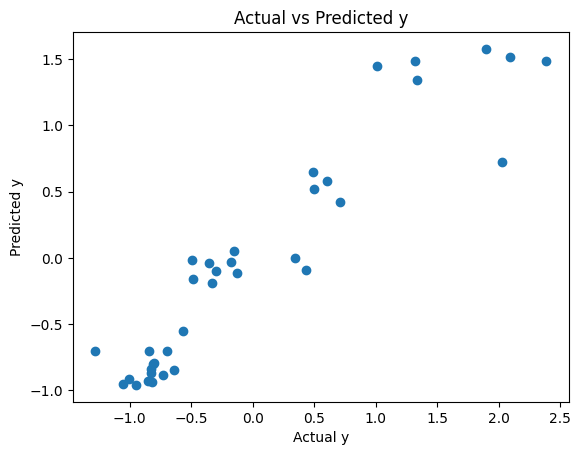

In [5]:
import matplotlib.pyplot as plt

# Predict the values using the trained model
y_pred = model.predict(X_scaled)

# Plot the scatterplot
plt.scatter(y_scaled, y_pred)
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Actual vs Predicted y')
plt.show()

On a range of network structures from very small like 5 parameters to larger (maximum 500 params), perform 10 runs of function fit_mlp random seeds and report average training and test loss. Store results together with the number of parameters for each structure.

In [37]:
import numpy as np

# Define the range of network structures
network_structures = [
    (1,), (2,), (3,), (4,), (5,), (10,), (20,), (50,), (100,), (200,), (500,)
]
# New prompt here: Add second layer with 5 neurons to each structure
network_structures = [(n, 5) for n in [1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500]]
# Generate network structures with a constant number of hidden neurons (e.g., 10) and increasing depth

# Initialize lists to store results
results = []

# Perform 10 runs for each network structure
for structure in network_structures:
    train_losses = []
    test_losses = []
    
    for seed in range(10):
        model, train_loss, test_loss = fit_mlp(X_scaled, y_scaled, hidden_layer_sizes=structure, test_size=0.2, random_state=seed)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    
    avg_train_loss = np.mean(train_losses)
    avg_test_loss = np.mean(test_losses)
    num_params = sum([np.prod(layer.size) for layer in model.coefs_]) + sum([np.prod(layer.size) for layer in model.intercepts_])
    
    results.append({
        'structure': structure,
        'num_params': num_params,
        'avg_train_loss': avg_train_loss,
        'avg_test_loss': avg_test_loss
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

   structure  num_params  avg_train_loss  avg_test_loss
0     (1, 5)          21        0.632642       0.697959
1     (2, 5)          31        0.227966       0.303977
2     (3, 5)          41        0.172833       0.242846
3     (4, 5)          51        0.109338       0.202405
4     (5, 5)          61        0.111601       0.193803
5    (10, 5)         111        0.105907       0.170329
6    (20, 5)         211        0.094252       0.172266
7    (50, 5)         511        0.095419       0.167688
8   (100, 5)        1011        0.086519       0.192407
9   (200, 5)        2011        0.078965       0.214396
10  (500, 5)        5011        0.078480       0.196174


plot average training and testing loss as a function number_of_parameters

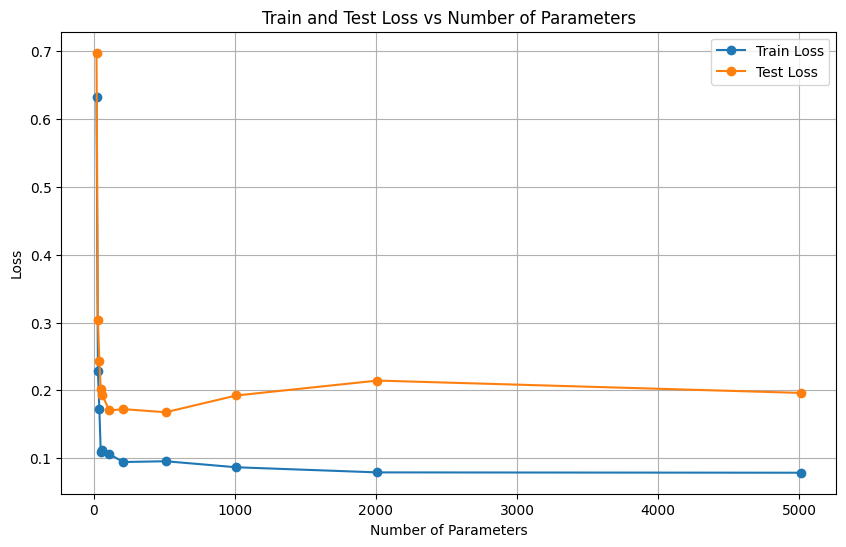

In [38]:
import matplotlib.pyplot as plt

# Extract the number of parameters, train loss, and test loss from the results DataFrame
num_params = results_df['num_params']
avg_train_loss = results_df['avg_train_loss']
avg_test_loss = results_df['avg_test_loss']

# Plot the train and test loss
plt.figure(figsize=(10, 6))
plt.plot(num_params, avg_train_loss, label='Train Loss', marker='o')
plt.plot(num_params, avg_test_loss, label='Test Loss', marker='o')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')
plt.title('Train and Test Loss vs Number of Parameters')
plt.legend()
plt.grid(True)
plt.show()

run model with structure (6,6,5)

In [15]:
model, train_loss, test_loss = fit_mlp(X_scaled, y_scaled, (6,6,5), test_size=0.2, random_state=42)


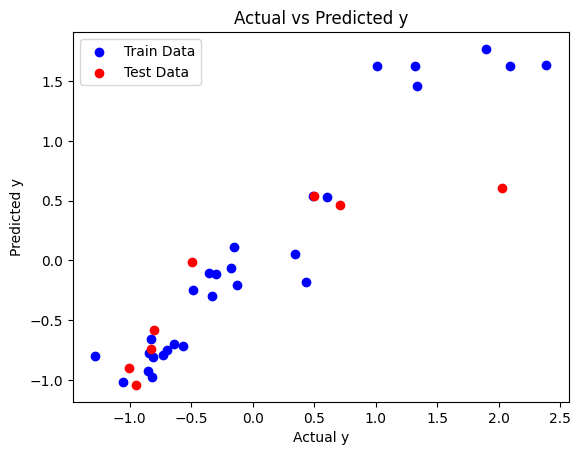

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Predict the values using the trained model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot the scatterplot
plt.scatter(y_train, y_train_pred, color='blue', label='Train Data')
plt.scatter(y_test, y_test_pred, color='red', label='Test Data')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Actual vs Predicted y')
plt.legend()
plt.show()

## The last layer of a NN can be intrepreted as features used in linear regression

Let's see how the learned features look like

evaluate output of all layers of teh network, plot output of the last second layer for the given input

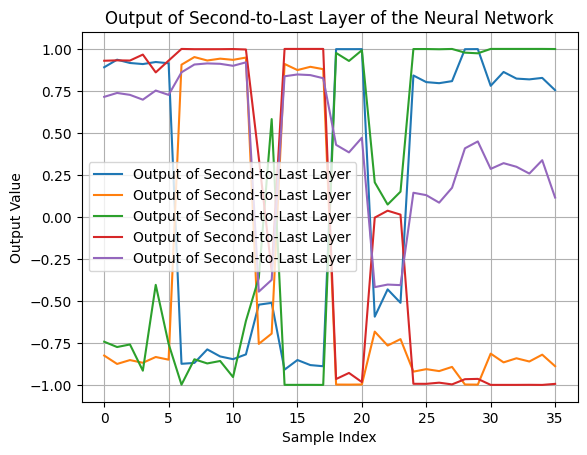

In [39]:
# Evaluate outputs of each layer of the neural network
layer_outputs = [X_scaled]
for i in range(len(model.coefs_)):
    layer_input = layer_outputs[-1]
    layer_output = np.tanh(np.dot(layer_input, model.coefs_[i]) + model.intercepts_[i])
    layer_outputs.append(layer_output)

# Get the output of the second-to-last layer for the given input
second_last_layer_output = layer_outputs[-2]

# Plot the output
plt.plot(second_last_layer_output, label='Output of Second-to-Last Layer')
plt.xlabel('Sample Index')
plt.ylabel('Output Value')
plt.title('Output of Second-to-Last Layer of the Neural Network')
plt.legend()
plt.grid(True)
plt.show()